**<font size="6">Part 1:Methods for Asian Options</font>**

For this first part of the project, we are looking at pricing an Asian option comparing different variance reduction techniques.

An Asian option is a type of financial derivative similar to a call option but with a different method of calculating the payoff. This is determined by the average underlying price over some preset time interval.

Asian options were originated in Asian markets to prevent option traders from attempting to manipulate the price of the underlying on the exercise date.
In this project we consider the following payoff:

$$\max\left( \frac{1}{N} \sum_{n=1}^{N} S_n - K, 0 \right)$$

Where $S_n$ are the daily closing prices of the underlying and $K$ is the fixed strike price. The option corresponding to this payoff function is called a Fixed Strike Asian Call Option with Discrete Arithmetic Average.
For the underlying process we will use geometric Brownian motion:

$$dS_t = rS_t dt + \sigma(S_t, t) S_t dW$$

To allow for the possibility that volatility can depend on the current time $t$ and current value of the underlying asset, we will use a local volitility function.

The code below is just used to import packages and set up parameters.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
# Set parameters
S = 100
K = 110
T = 3
r = 0.05

Npaths = 1000
rng = np.random.default_rng(12345) # to allow for replication

**<font size="5">Local Volitility</font>**


Implementing the local volitility given by the below function:

$$
\sigma(S,t) = \sigma_0 (1 + \sigma_1 \sin(2\pi t))(1 + \sigma_2 exp(-S/50))
$$


$\sigma_0$, $\sigma_1$, $\sigma_2$ are parameters. The $\sin$ term accounts for yearly variations in the volatility. The $\sigma_2 exp(-S/50)$ term means the volatility increases with $S$ if $\sigma_2 >0$, but decreases with $S$ if $\sigma_2 <0$.
$$
\sigma_0 = 0.2\\
\sigma_1 = 0.3\\
\sigma_2 = 0.5
$$

In [40]:
#local volitility
def localvol(S,t):
  sigma0 = 0.2
  sigma1 = 0.3
  sigma2 = 0.5
  sigma = sigma0*(1+sigma1*np.cos(2*np.pi*t)) * (1 + sigma2*(np.exp(-S/50))) # the function above
  return sigma


**<font size="5">Euler Time Stepping</font>**

For this project, we are using Euler time stepping with a step size of one day. This is a numerical method used to approximate the solution of differential equations by breaking down the continuous-time evolution into discrete time steps.

In context with the Asian option, we use Euler time stepping to simulate the paths of the underlying asset's price over time, modelled by Geometric Brownian Motion as mentioned before.

Please see the code below:

In [41]:
def SDE_timestepper(S0, K, T, r, Npaths):

    # Simulate GBM paths

    # Use a time step of 1 day assuming 260 days/year
    Nsteps = int(260 * T)

    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S = np.zeros((Nsteps+1, Npaths))

    # Time step starting from initial condition
    S[0,:] = S0
    for n in range(Nsteps):
        dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
        S[n+1,:] = S[n,:] * (1. + r*dt + localvol(S[n,:],t[n]) * dW[:])

    return t, S # returns the time and the path of simulated prices


To easily visualise what this time stepper does, I will include code below to plot the skeleton paths.

Please see code below:

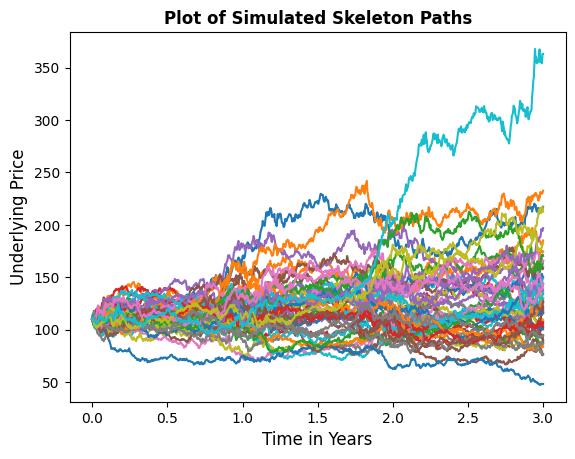

In [42]:
t, S = SDE_timestepper(110, K, T, r, 50) # calling the function
plt.plot(t,S) # simple plot
plt.title("Plot of Simulated Skeleton Paths",fontweight='bold')
plt.xlabel('Time in Years', fontsize = 12)
plt.ylabel('Underlying Price', fontsize = 12)
plt.show()

**<font size="5">Pricing the Asian Option (Naive)</font>**

Now that we have defined the local volitility and the time stepper, we can begin to price this Option.

The code below uses the simulated paths from the time stepper to calculate the corresponding payoff. To then find the average price and variance (as every path is different) we can compute the mean and variance fairly easily as shown below:

In [43]:
def SDE_asian_call(S0, K, T, r, Npaths):

    # price Asian call option by simulating GBM paths

    t, S = SDE_timestepper(S0, K, T, r, Npaths)

    # for European call, useful for testing
    #fS = np.exp(-r*T)*np.maximum(S[-1,:]-K,0)
    # for Asian call
    fS = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)


    price = np.mean(fS) # compute price
    variance = np.var(fS)# variance

    return price, variance


Now, just testing to make sure my code gives sensible results, I am calling the function with a starting price of 110.

From the output below, a price of 13 seems appropriate, however, a variance of 300 seems quite large. We will explore this later in the project. (See below)

In [44]:
option_price_1, option_variance_1 = SDE_asian_call(110, K, T, r, Npaths)
print("Asian Option Price with initial condition 110:", option_price_1)
print("Variance:", option_variance_1)

Asian Option Price with initial condition 110: 13.779661234307168
Variance: 305.9588988843262


**<font size="5">Antithetic Variance Reduction</font>**

I will now look at pricing the option using antithetic variance reduction.

Antithetic variance reduction is a technique used in Monte Carlo simulations to reduce the variance of the estimated outcomes.

In Monte Carlo simulations, random sampling is used to generate various possible outcomes for an uncertain variable (e.g., the future price of an asset). However, Monte Carlo simulations can suffer from high variance (as shown earlier), leading to less accurate estimations. Antithetic variance reduction is a method to mitigate this variance.

Instead of generating one random sample for each simulation, antithetic variance reduction involves generating pairs of samples. This is created in such a way that each sample will typically move in opposite directions.

By considering the average of the original outcome and its antithetic counterpart, the variance of the estimates is reduced. The idea is that the errors in the estimation tend to cancel out to some extent because of the negative correlation between the pairs.

In the code below, I have modified the original time stepper to take into account these random sample pairs (Sp and Sm).
Please see code below:

In [45]:
def SDE_timestepper_ant(S0, K, T, r, Npaths):

    # Simulate GBM paths
    # returns the time array and the paths

    # Use a time step of 1 day assuming 260 days/year
    Nsteps = int(260 * T)

    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)

    Sp = np.zeros((Nsteps+1, Npaths))
    Sm = np.zeros((Nsteps+1, Npaths))

    # Time step starting from 2 initial conditions
    Sp[0,:] = S0
    Sm[0,:] = S0
    for n in range(Nsteps):
        dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
        Sp[n+1,:] = Sp[n,:] * (1. + r*dt + localvol(Sp[n,:],t[n]) * dW[:])
        Sm[n+1,:] = Sm[n,:] * (1. + r*dt - localvol(Sm[n,:],t[n]) * dW[:])

    return Sp, Sm



Now, in a similar way to before, we can now price this Asian option using antithetic variance reduction.

The method is very similar apart form this time, we calculate two payoff arrays (fSTp and fSTm for Sp and Sm respectively) and then calculate the mean and variance of an array $Z$, which is the average of the two payoff arrays.

This method should result in a reduced variance.

Please see code below:

In [46]:
def SDE_asian_call_ant(S0, K, T, r, Npaths):

    # price Asian call option by simulating GBM paths
    # returns the price and variance


    Sp, Sm = SDE_timestepper_ant(S0, K, T, r, Npaths)


    # for European call, useful for testing
    #fS = np.exp(-r*T)*np.maximum(S[-1,:]-K,0)
    # for Asian call

    fSTp = np.exp(-r*T)*np.maximum(np.mean(Sp, axis = 0) - K, 0) # payoffs
    fSTm = np.exp(-r*T)*np.maximum(np.mean(Sm, axis = 0) - K, 0)


    z = (fSTp + fSTm)/2 #average of the two
    price = np.mean(z)
    variance = np.var(z)
    return price, variance


Just testing the code again, we see from the below output a price of 13 again but with a much smaller variance of around 65 compared to 300. So far this is suggesting that this method may be superior when pricing an Asian option due to the lower variance while maintaining an accurate price.

In [47]:

option_price_2, option_variance_2 = SDE_asian_call_ant(110, K, T, r, Npaths)
print("Asian Option Price with antithetic variance reduction:", option_price_2)
print("Variance:", option_variance_2)

Asian Option Price with antithetic variance reduction: 12.480852094679783
Variance: 65.2512346380713


**<font size="5">Control Variates</font>**

Formal definiton: Control variates are a technique used in Monte Carlo simulations to improve the estimation accuracy of a desired outcome. This method is employed to reduce the variance of the estimate by introducing a correlated auxiliary variable whose true value is known or can be accurately estimated.

The above definition can seem quite complicated. In laymans terms, we can use a known or easily estimated variable that is related to our goal. By utilising this relationship, we can reduce the uncertainty in the estiamte.

The below code includes both the modified time stepper and the pricer function.

We have modified the time stepper by incorporating the stochastic differential equation $Z$. The pricer function underneath has clear comments detailing the steps and differences to the earlier methods.

Please see code below:

In [48]:
def SDE_timestepper_CV(S0, K, T, r, Npaths):
    # Simulate GBM paths for Zt using the provided local volatility function
    # returns the time array and the paths for Zt

    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    Z = np.zeros((Nsteps + 1, Npaths))
    Z[0, :] = S0

    for n in range(Nsteps):
        dW = np.sqrt(dt) * np.random.normal(0, 1, Npaths)
        Z[n + 1, :] = Z[n, :] * (1. + r * dt + localvol(Z[n, :], t[n]) * dW[:])

    return t, Z

def asian_option_price_with_control_variate(S0, K, T, r, Npaths):
    t, Z = SDE_timestepper_CV(S0, K, T, r, Npaths)

    # Calculate Asian option price
    asian_payoff = np.exp(-r * T) * np.maximum(np.mean(Z[-1, :]) - K, 0)

    # Calculate ZT mean for the control variate
    Z_mean = np.mean(Z[-1, :])

    # Calculate the control variate
    control_variate = np.exp(-r * T) * (Z[-1, :] - Z_mean)

    # Adjust the Asian option price using the control variate
    price = asian_payoff - np.mean(control_variate)
    variance = np.var(asian_payoff - control_variate)


    return price, variance
 # Example usage
S0 = 110
K = 110
T = 3
r = 0.05
Npaths = 1000

option_price, option_variance = asian_option_price_with_control_variate(S0, K, T, r, Npaths)
print("Asian Option Price with Control Variate and Local Volatility:", option_price)
print("Variance of the Adjusted Option Price:", option_variance)

Asian Option Price with Control Variate and Local Volatility: 18.173099019067546
Variance of the Adjusted Option Price: 1986.6010212629997


From the above output testing the code, we can see a price of around 15, slighy higher compared to the previous methods, but with an extremely larger variance. This suggests that this method does not perform to a high standard when pricing an Asian option and does not yield accurate results.

**<font size="5">Forming Confidence Intervals</font>**

In the code below, we can price the option at 3 different spot prices related to strike price $K$: <br>
$S_0 < K$, $S_0 = 100$<br> $S_o = K$, $S_0 = 110$<br> $S_o > K$, $S_o = 120$



The following code will be used to calculate the confidence intervals for these different spot rates: <br>
(Assuming $Q_{0.025}$ = $1.96$)

In [49]:
print('Naive:')
p1, v1 = (SDE_asian_call(100, K, T, r, Npaths)) # returns the price and variance for each scenario (naive)
p2, v2 = (SDE_asian_call(110, K, T, r, Npaths))
p3, v3 = (SDE_asian_call(120, K, T, r, Npaths))
print(p1 - 1.96 * np.sqrt(v1), p1 + 1.96 * np.sqrt(v1))
print(p2 - 1.96 * np.sqrt(v2), p2 + 1.96 * np.sqrt(v2))
print(p3 - 1.96 * np.sqrt(v3), p3 + 1.96 * np.sqrt(v3))
print('Antithetic:')
pa1, va1 = (SDE_asian_call_ant(100, K, T, r, Npaths))# returns the price and variance for each scenario (antithetic)
pa2, va2 = (SDE_asian_call_ant(110, K, T, r, Npaths))
pa3, va3 = (SDE_asian_call_ant(120, K, T, r, Npaths))
print(pa1 - 1.96 * np.sqrt(va1), pa1 + 1.96 * np.sqrt(va1))
print(pa2 - 1.96 * np.sqrt(va2), pa2 + 1.96 * np.sqrt(va2))
print(pa3 - 1.96 * np.sqrt(va3), pa3 + 1.96 * np.sqrt(va3))
print('Control:')
pcv1, vcv1 = (asian_option_price_with_control_variate(100, K, T, r, Npaths))# returns the price and variance for each scenario (control)
pcv2, vcv2 = (asian_option_price_with_control_variate(110, K, T, r, Npaths))
pcv3, vcv3 = (asian_option_price_with_control_variate(120, K, T, r, Npaths))
print(pcv1 - 1.96 * np.sqrt(vcv1), pcv1 + 1.96 * np.sqrt(vcv1))
print(pcv2 - 1.96 * np.sqrt(vcv2), pcv2 + 1.96 * np.sqrt(vcv2))
print(pcv3 - 1.96 * np.sqrt(vcv3), pcv3 + 1.96 * np.sqrt(vcv3))

Naive:
-17.84600970084292 32.53749778636099
-22.428085561956586 46.54613156938921
-21.397410752001456 59.322338153861914
Antithetic:
-7.740951680698587 21.487968349932096
-3.961175363246708 29.680298234695982
3.8612818477668327 35.36011356393529
Control:
-68.23089195552897 76.63841282955129
-68.27119646900255 95.98674607148462
-64.073007066298 117.52030842577796


**Confidence Intervals**<br>
From the code above we can obtain a 95% confidence interval for the price of the option in each case: <br>
**Naive approach:** <br>
$S_0 < K$, $S_0 = 100$: $(-18.0, 32.6)$<br>
$S_o = K$, $S_0 = 110$: $(-15.0, 38.9)$<br>
$S_o > K$, $S_o = 120$: $(-22.4, 58.4)$
<br><br>
**Antithetic Variance Reduction:** <br>
$S_0 < K$, $S_0 = 100$: $(-7.7, 23.7)$<br>
$S_o = K$, $S_0 = 110$: $(-3.3, 29.6)$<br>
$S_o > K$, $S_o = 120$: $(-3.9, 36.0)$
<br><br>
**Control Variate (Zt):** <br>
$S_0 < K$, $S_0 = 100$: $(-70.9, 81.4)$<br>
$S_o = K$, $S_0 = 110$: $(-66.6, 94.1)$<br>
$S_o > K$, $S_o = 120$: $(-66.3, 111.8)$

In all cases, we can see the price of the option increases with $S_0$. From a finance perspective, fundamentally we would expect this as assuming Geometric Brownian Morion, the higher your initial price, the higher the expect payoff.

The relationship with the intial condition and the varaince is not very clear, however, there is a slight trend. We typically see that intial prices lower than the strke price have a lower variance. This is becasue, with a starting price less than the strike, there will be more zeros (no payoffs) in the array, therefore when calcuating the variance these zeros will have an affect. It is important for us to understand this concept as it does affect our results.

Clearly fron the intervals, the antithetic variance reduction method has a smaller confidnece interval in each scenario. This is proof that this method has a smaller variance and therefore depicts more precise confidence intervals. Further supporting this method being the most accurate for pricing an Asian Option.

**<font size="5">Analysis</font>**

There is also the discussion of computational efficiency. The advantages of the Naive method is that it's easy to understand and use, returning an accurate price of the option. However, the variance is fairly large, suggesting that this method is not very precise.

The antithetic approach also returns an accurate price of the option, however to its' benefit, it yields a much smaller variance without drastically decreasing the computational efficiency. Albeit, the comlexity does increase slighlty, however this increase is not enough to disregard the model. Overall, this method is definitely prefered (most efficient) due its' smaller variance and neglible increase in complexity.

The control variate approach, whilst could be very useful, does not fit well to pricing an Asian Option. Whilst it returns an accurate price, the variance is far too large to even consider this model.

**<font size="5">Plot of Option Prices</font>**

The code below creates a plot of the option prices as a function of spot prices from $S_0 = 10$ to $S_0 = 180$ using the antithetic variance reduction method, which yield the smallest variance. The plot also explores how time to maturity affects the price.

**Please note:** The code below uses 500 number of paths rather 1000 due to computational time. This code will take approximately 15 seconds to run.



In [50]:
S0_range = np.linspace(10,180,171) # for T = 3
Sprices = []
for i in (S0_range):
  price, _ = SDE_asian_call_ant(i,K = 110,T = 3,r = 0.05,Npaths = 500)
  Sprices.append(price)
vector = np.array(Sprices)

In [51]:
S0_range_2 = np.linspace(10,180,171) # for T = 10
Sprices_2 = []
for i in (S0_range):
  price_2, _ = SDE_asian_call_ant(i,K = 110,T = 10,r = 0.05,Npaths = 500)
  Sprices_2.append(price_2)
vector_2 = np.array(Sprices_2)

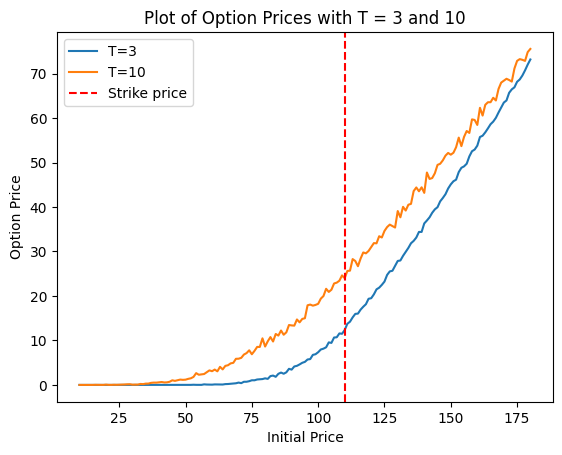

In [52]:
plt.plot(S0_range, vector, label='T=3')
plt.title("Plot of Option Prices with T = 3 and 10")
plt.plot(S0_range_2, vector_2, label='T=10')
plt.axvline(x = 110, color='red', linestyle='--', label = 'Strike price')
plt.xlabel("Initial Price")
plt.ylabel("Option Price")
plt.legend()

From the above plot, we can see the price of the Asian Option increases exponentially with a higher initial price. From a financial perspectice, as mentioned earlier in this project, we would expect this due to the higher expected payoff.

Directly looking at $T$ 'time to maturty', we can easily see that for all values of $S_0$, $T$ = 10 has a higher Option Price.  Longer maturities allow for a more extensive averaging window, smoothing out short-term fluctuations and reducing the impact of extreme market movements on the option's value. This diminished sensitivity to short-term volatility coupled with a longer timeframe increases the option's stability and reduces risk, contributing to a higher price. Additionally, the extended time horizon amplifies the influence of interest rates, enhancing the option's value.



**European Call Option Comparison**

I will also look at comparing this Asian option to a simple call option.

Please see code below to price the call option (takes approximately 10 seconds):

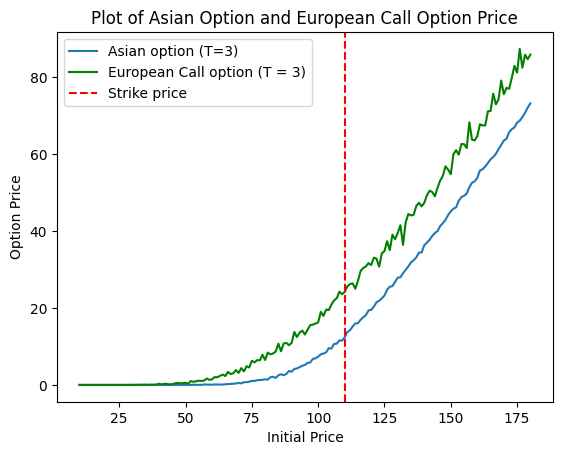

In [54]:
def calculate_call_option_price(S0, K, T, r, Npaths):
    t, paths = SDE_timestepper(S0, K, T, r, Npaths)
    ST = paths[-1, :]  # Terminal prices
    payoff = np.maximum(ST - K, 0)  # Call option payoff at maturity
    discount_factor = np.exp(-r * T)
    option_price = discount_factor * np.mean(payoff)  # Monte Carlo estimation

    return option_price
S0_range_3 = np.linspace(10, 180, 171)  # Initial values
Sprices_3 = []

for i in S0_range_3:
    price_3 = calculate_call_option_price(i,K = 110,T = 3,r = 0.05,Npaths = 1000) # for T = 3
    Sprices_3.append(price_3)

vector_3 = np.array(Sprices_3)# for Plotting
plt.plot(S0_range, vector, label='Asian option (T=3)')
plt.title("Plot of Asian Option and European Call Option Price")
plt.plot(S0_range_3, vector_3,color = 'green', label = 'European Call option (T = 3)')
plt.axvline(x = 110, color='red', linestyle='--', label = 'Strike price')
plt.xlabel("Initial Price")
plt.ylabel("Option Price")
plt.legend()

From a financial perspective, we can see that for all values the European Call option has a higher price than the Asian.

European Call options typically have higher prices than Asian options due the payoff. A call option's value is linked directly to how much the underlying asset's price exceeds the strike price at expiration, (expiration being the key word). As the Asian option looks at an average of the assets path, this 'smoothening' effect will result in a lower payoff. An easy example to help explain, if an asset starts at $S_0$ = 100  with $K$ = 100 and steadily increases to 110 at maturity. The Euroepan Call option payoff will be 10 whereas the Asian will be lower, as it takes the values when $S$ was less than 110 into account.

Due to the explanation above, we would expect to see the European Call option price higher than the Asian.



**For even further analysis: (interest rates)**

There was one more factor I wanted to consider changing, the interest rate $r$.

The code below is very similar to before, producing a plot comparing the interest rates of an Asian option.

**Please note:** The code below takes approximately 15 seconds.

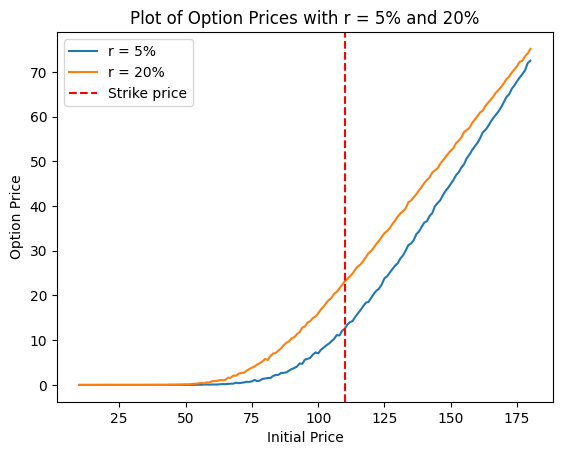

In [55]:
S0_range = np.linspace(10,180,171) # for r = 5%
Sprices = []
for i in (S0_range):
  price, _ = SDE_asian_call_ant(i,K = 110,T = 3,r = 0.05,Npaths = 1000)
  Sprices.append(price)
vector = np.array(Sprices)

S0_range_3 = np.linspace(10,180,171) # for r = 20%
Sprices_3 = []
for i in (S0_range_3):
  price_3, _ = SDE_asian_call_ant(i,K = 110,T = 3,r = 0.2,Npaths = 1000)
  Sprices_3.append(price_3)
vector_3 = np.array(Sprices_3)

plt.plot(S0_range, vector, label='r = 5%')
plt.title("Plot of Option Prices with r = 5% and 20%")
plt.plot(S0_range_3, vector_3, label='r = 20%')
plt.axvline(x = 110, color='red', linestyle='--', label = 'Strike price')
plt.xlabel("Initial Price")
plt.ylabel("Option Price")
plt.legend()


To briefly analyse this plot, we can see that for a higher interest rate (20%), the price of the Asian option is more expensive when compared to an interest rate of 5% for all intial sport prices.

**<font size="5">Deltas</font>**

I will now generate a function to find the delta of an Asian Option.

The provided code below estimates the delta and variance of an Asian call option using Monte Carlo simulations and the likelihood method. It generates future asset prices through a simulation based on the local volatility function, calculates the option's payoff, and employs the likelihood method to derive the delta, representing the option's sensitivity to changes in the underlying asset's price, along with the variance of this estimation across simulations.

Please see code below:

In [56]:
def MC_asian_call_delta_likelihood(S, K, T, r, N):
    S0 = S
    t = 0

    X = np.random.normal(0, 1, N)
    ST = np.zeros(N)
    for i in range(N):
        sigma_t = localvol(S0, t)
        ST[i] = S0 * np.exp((r - 0.5 * sigma_t**2) * T + sigma_t * np.sqrt(T) * X[i])

    avg_ST = np.mean(ST)  # Average of the future prices

    fST = np.exp(-r * T) * np.maximum(ST - K, 0)  # Payoff for Asian option

    Z = (np.log(avg_ST / S0) - (r - 0.5 * localvol(S0, 0)**2) * T) / (S0 * localvol(S0, 0)**2 * T) * fST

    delta = np.mean(Z)
    variance = np.var(Z)

    return delta, variance

In [57]:
delta, variance_d = MC_asian_call_delta_likelihood(S = 110, K = 100, T = 3, r = 0.05,N = 1000)
print("Asian Option Delta:", delta)
print("Variance:", variance_d)

Asian Option Delta: 0.16931740076412508
Variance: 0.06361119094023013


From the above output testing the code, we can see the function returned a sensible delta of 0.15 with a small corresponding variance of 0.05.

Financially what does this mean?

A delta of 0.15 for an option indicates that for every $1 increase in the underlying asset's price, the option's price is expected to rise by approximately 15 cents.

In a similar way to before, I will produce a plot of the deltas over the same range of spot prices as before.

Please see code below:

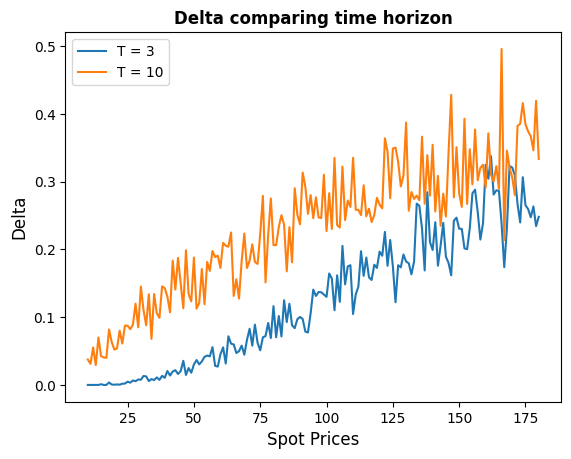

In [58]:
# for T = 3
S0_range_delta = np.linspace(10,180,171)
Sprices_delta = []
for i in (S0_range_delta):
  delta, _ = MC_asian_call_delta_likelihood(i,K = 100,T = 3,r = 0.05,N = 1000)
  Sprices_delta.append(delta)
vector_delta = np.array(Sprices_delta)
# for T = 10
S0_range_delta_2 = np.linspace(10,180,171)
Sprices_delta_2 = []
for i in (S0_range_delta_2):
  delta_2, _ = MC_asian_call_delta_likelihood(i,K = 100,T = 10,r = 0.05,N = 1000)
  Sprices_delta_2.append(delta_2)
vector_delta_2 = np.array(Sprices_delta_2)
plt.plot(S0_range_delta,vector_delta, label = 'T = 3')
plt.plot(S0_range_delta_2,vector_delta_2, label = 'T = 10')
plt.title("Delta comparing time horizon", fontweight='bold')
plt.xlabel('Spot Prices', fontsize = 12)
plt.ylabel('Delta', fontsize = 12)
plt.legend()
plt.show()

The plot above reveals a consistent trend where options with a longer time to expiration (T = 10) consistently exhibit higher deltas compared to options with shorter expirations (T = 3). This observation suggests that longer-term options showcase a greater sensitivity to changes in the underlying asset's price.

The higher deltas associated with longer expirations signify an increased responsiveness of these options to fluctuations in the asset's price, likely due to their extended timeframe, emphasizing their higher potential for capturing and reflecting changes in the underlying asset's value.

Also worth mentioning, the volitility of both deltas are very high, suggesting that for an Asian option, the delta value is very responsive and can deviate from its original value given only a slight change in the initial spot price $S_0$. Moreover, we can also see that the volitility increases with a higher inital spot price.

**<font size="5">Empirical Analysis and Conclusion</font>**

In this part of the project we have looked at pricing an Asian option using different methods to reduce the variance, whilst also developing a function to calculate the correspondinig deltas. We also explored how the option price would change when adjusting the time to maturity and the interest rate alongside other interesting factors.

We have seen that across all methods, an Asian option with a higher initial spot price will be more expensive and have a higher delta than a lower initial spot price. Financially, we explained earlier the reason for this is because we would expect a larger payoff.

When evaluating different methods, it seems that the antithetic variance reduction method does produce an accurate result with the smallest variance. Whilst computational time was hard to test, we didn't see any major issues until producing the plots for $T$ = 10. However, upon further analysis, the extra computational time was not due to the variance reduction method but the loop creating the array. Outside of this notebook I tested all 3 methods and found the computational time difference was not significant.

We saw that the control variate had an extremely large variance and an inflated price in comparision to the other methods, suggesting that this method was not optimal for pricing an Asian option.

The naive approach is an interesting one. This method does provide an accurate price for the Asian option with a slightly higher variance than the antithetic approach. If you are looking for a simple model to price an Asian option, then this method is by far superior. However, in the real world, pricing options needs to be accurate and can have serious implications if priced incorrectly. Therefore in my opinion, I would suggest the antithetic approach is the most efficient in pricing an Asian option.

